# GRAFT Model Demo
This notebook shows example of running graft model.
Using this you can test the GRAFT model on a set of pre-defined images or also on your **custom region downaloadable using earthengine**.

## Setup


### Before starting:
Make sure you are using a runtime with GPU (T4 for examples).

You also need to install `omegaconf` library using the command below. colab will ask you to restart the runtime however you do **not** need to do it.

In [1]:
!pip install omegaconf

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.5/759.5 kB 18.6 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144592 sha256=4bc7ded1500fdb973393d726c121ae10f2b81122913f2190b54b66730da6524e
  Stored in directory: /home/ianyang/.cache/pip/wheels/d5/b3/74/a35b66048c9de6631cd74cbc9475e6feb3e69a467983446bd8
Successfully built antlr4-python3-runtime


### Import libraries and utility functions

In [1]:
from os.path import join, isfile, isdir
from os import listdir
from multiprocessing import Pool
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from shutil import copy
import torch.nn as nn
import requests
import matplotlib.pyplot as plt
import urllib.request
from transformers import CLIPVisionModelWithProjection, CLIPTextModelWithProjection, AutoTokenizer
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output
import io

%matplotlib inline

In [2]:
def download_with_progress_bar(url, output_path):
    with urllib.request.urlopen(url) as response:
        total_size = int(response.headers.get('Content-Length', 0))
        block_size = 1024  # 1 Kibibyte
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
        with open(output_path, 'wb') as file:
            while True:
                data = response.read(block_size)
                if not data:
                    break
                file.write(data)
                progress_bar.update(len(data))

        progress_bar.close()

    print(f"File downloaded and saved to {output_path}")


### Model definition

In [3]:
class GRAFT(nn.Module):
    def __init__(self, CLIP_version="openai/clip-vit-base-patch16", temp=False, bias_projector=True):
        super().__init__()
        # satellite image backbone
        self.satellite_image_backbone = CLIPVisionModelWithProjection.from_pretrained(CLIP_version)
        self.patch_size = self.satellite_image_backbone.config.patch_size

        self.projector = nn.Sequential(
            nn.LayerNorm(self.satellite_image_backbone.config.hidden_size, eps=self.satellite_image_backbone.config.layer_norm_eps),
            nn.Linear(self.satellite_image_backbone.config.hidden_size, self.satellite_image_backbone.config.projection_dim, bias=bias_projector),
        )
        self.patch_size = self.satellite_image_backbone.config.patch_size
        self.norm_dim = -1

        self.temp = temp
        if temp:
            self.register_buffer("logit_scale", torch.ones([]) * (1 / 0.07))

    def forward(self, image_tensor):
        # Extract features from satellite images
        # B x 197 x 768 for VIT-B/16
        hidden_state = self.satellite_image_backbone(image_tensor).last_hidden_state
        # B x 197 x 512
        satellite_image_features = F.normalize(self.projector(hidden_state), dim=self.norm_dim)
        # get the satellite image features
        return satellite_image_features

    def forward_features(self, image_tensor):
        # Extract features from satellite images
        # B x 512 for VIT-B/16
        embed = self.satellite_image_backbone(image_tensor).image_embeds
        # B x 512
        satellite_image_features = F.normalize(embed)
        return satellite_image_features

### Load GRAFT Model

Visit the [GRAFT agreement page](https://docs.google.com/forms/d/e/1FAIpQLSeb1U8eE_EfooAU_WEuGNlou3OSEKe99vIm-HuuyOPbp2Weeg/viewform) and sign it to recieve the model checkpoint directory.
Use the checkpoint directory below instead of `PLACEHOLDER`.

In [4]:
model_dir = 'https://graft.cs.cornell.edu/static/models/e96c9fbd1ee2ca1b3c253c94761e1ffb/'

In [5]:
device="cuda"
model = GRAFT(temp=True, bias_projector=False).to(device)
ckpt_url = model_dir+'/graft_naip.ckpt'
output_path = "model.ckpt"
ckpt_file = download_with_progress_bar(ckpt_url, output_path)
transform = transforms.Compose([transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])])
sd = torch.load(output_path, weights_only=False)
model.load_state_dict(sd['state_dict'], strict=False)
textmodel = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch16").eval().to(device)
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

100%|██████████| 1.03G/1.03G [00:50<00:00, 20.4MiB/s]   


File downloaded and saved to model.ckpt


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

### A zero-shot classifer using the above

In [6]:
def zero_shot_classification(image, classes=None):
  with torch.no_grad():
    tr_image = transform(image).unsqueeze(0).to(device)
    image_feature = model.forward_features(tr_image)
  if classes is not None:
    texts = classes
  else:
    texts = ["tennis courts", "parking lot", "farmland", "lake", "park", "powerlines", "University Campus", "Beach", "Freeway"]
  with torch.no_grad():
    textsenc = tokenizer(texts, padding=True, return_tensors="pt").to(device) #tokenize
    class_embeddings = F.normalize(textmodel(**textsenc).text_embeds, dim=-1) #embed with text encoder
  classlogits = image_feature.cpu().numpy() @ class_embeddings.cpu().numpy().T
  fig = plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Input Image")
  plt.imshow(image)
  plt.axis('Off')
  plt.subplot(1, 2, 2)
  plt.ylabel('Class matching score')
  plt.xlabel('Classes')
  plt.title("Graft best prediction: '{}'".format(texts[np.argmax(classlogits[0])]))
  plt.bar(range(len(classlogits[0])), classlogits[0])
  plt.xticks(range(len(texts)), texts, rotation=90)
  plt.show()
  return classlogits

## Run GRAFT on images

### Option 1: Choose from a list of images to run GRAFT on



Dropdown(description='Select an image:', options=(('Tennis', 'https://research.cs.cornell.edu/caco/data/graft/…

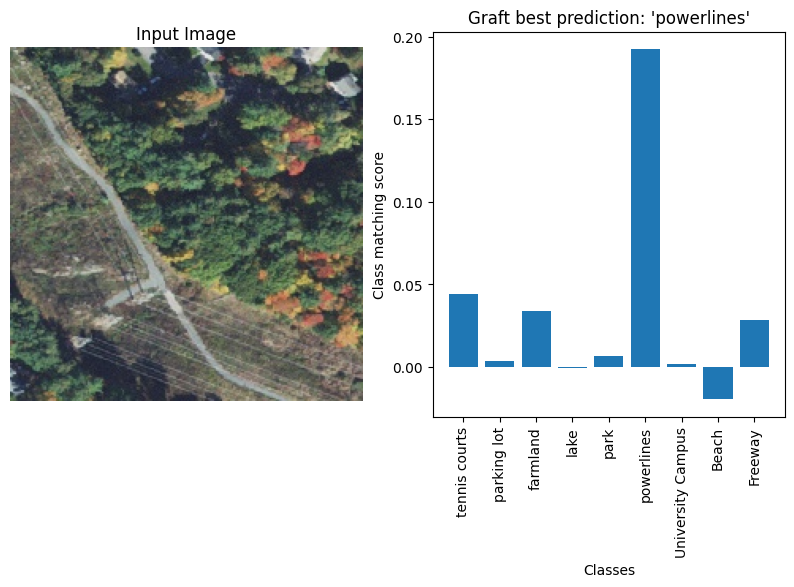

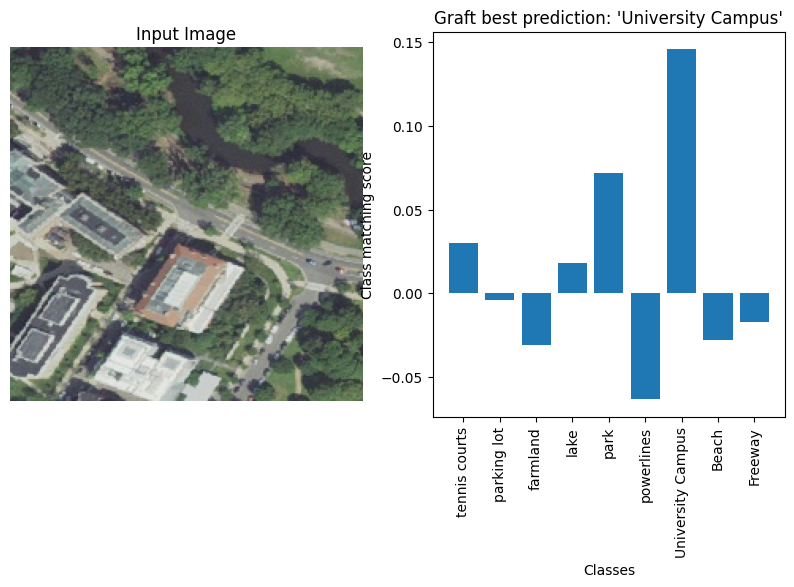

In [7]:
def read_image_from_url(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    return image

urls = [
    ("Tennis","https://research.cs.cornell.edu/caco/data/graft/MA/2020/00868/-7084200_4215600.jpg"),
    ("PowerLine","https://research.cs.cornell.edu/caco/data/graft/MA/2020/00669/-7121000_4252600.jpg"),
    ("University","https://research.cs.cornell.edu/caco/data/graft/MA/2020/00741/-7110000_4233800.jpg"),
    ("Freeway","https://research.cs.cornell.edu/caco/data/graft/MA/2020/00485/-7176600_4244400.jpg"),
    ("Beach","https://research.cs.cornell.edu/caco/data/graft/MA/2020/00871/-7081600_4255400.jpg")
]

dropdown = widgets.Dropdown(options=urls,description='Select an image:',disabled=False)

def on_dropdown_change(change):
    global image
    image = read_image_from_url(change['new'])
    # zero_shot_classification(image)
    zero_shot_classification(image)


dropdown.observe(on_dropdown_change, names='value')

display(dropdown)


### Option 2: Select your own area of interest

Use this [earthengine app](https://code.earthengine.google.com/748f3af3ca38b753bf8883e9da7f4045?hideCode=true) to download your own area of interest. See the video below (or [here in HD](https://graft.cs.cornell.edu//static/videos/diy_video.mp4)) to understand how to use the app.
![alt text](https://graft.cs.cornell.edu//static/videos/diy_video.gif)




Saving 1edb48468dbb1802446dedf951157e01-5e37703078e909b361a051936d4722f7_getPixels.jpeg to 1edb48468dbb1802446dedf951157e01-5e37703078e909b361a051936d4722f7_getPixels.jpeg


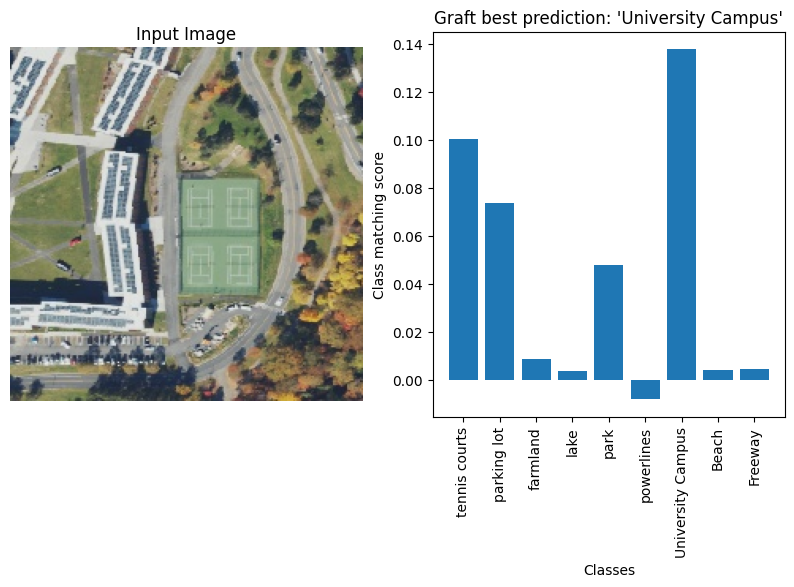

In [ ]:
from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded))
image = Image.open(image_path)
scores = zero_shot_classification(image)